Setup

In [2]:
!pip install opendatasets
#for downloading datasets from online sources like Kaggle and Google Drive using a simple Python command.

In [3]:
import opendatasets as od

In [4]:
from google.colab import files
files.upload()  # Select the `kaggle.json` file from your computer



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bachulakshmisravani","key":"0c4bab37c40fafec56d62acd20f4b36e"}'}

In [5]:
od.download("https://www.kaggle.com/deadskull7/fer2013")
# the datset fer2013 has images of categorised into 7 emotions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
# The training set consists of 28,709 exampsles and the public test set consists of 3,589 examples.

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013


Downloading dataset

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors.
# Torch.nn.Module is a base class for all neural network module

# Torchvision is a library for Computer Vision used along with PyTorch.
# It has utilities for efficient Image and Video transformations, some commonly used pre-trained models, and some datasets
# common image transformations are available in the torchvision.transforms module(like cropping, padding, brightness adjustment, quality modification, etc)

In [7]:

import os, shutil

if os.path.exists('data'):
    # If 'data' exists, check if 'fer2013.csv' is inside
    if os.path.exists('data/fer2013.csv'):
        print("fer2013.csv already exists in data directory, skipping move")
    else:
        # Move 'fer2013.csv' if it's not already in 'data'
        shutil.move('fer2013/fer2013.csv', 'data')
else:
    os.mkdir('data')
    shutil.move('fer2013/fer2013.csv', 'data')

# Use shutil.rmtree to remove the directory and its contents
if os.path.exists('fer2013'):
    shutil.rmtree('fer2013') # Changed from os.rmdir to shutil.rmtree

In [8]:
import sys,os
# The sys module in Python provides various functions and variables that are used to manipulate different parts of the Python runtime environment.

import numpy as np
# NumPy is a Python library used for working with arrays
import pandas as pd
# Pandas is a Python library for data analysis
import tensorflow as tf
# used to create Deep Learning models(for training ML models )
from tensorflow import keras
# Keras is an open-source high-level Neural Network library, it is capable enough to run on Theano, TensorFlow, or CNTK.
from tensorflow.keras.models import Sequential
# for arranging the Keras NN layers in a sequential order
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# flatten -Flattens the input. Does not affect the batch size.
# dense - forms a densely-connected NN layer
# dropout - helps prevent overfitting
# activation - contains functions to activate layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils

# Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
# Global average pooling operation for spatial data
# Conv2D creates a convolutional 2D layer with given filters

In [9]:
#checking whether the gpu is working fine

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Data Preprocessing

In [10]:
#reading file and extracting data

emotion_data = pd.read_csv('data/fer2013.csv')

# splitting the data into train and test sets

X_train,train_y,X_test,test_y=[],[],[],[]
for index, row in emotion_data.iterrows():
    val=row['pixels'].split(" ")
    if 'Training' in row['Usage']:
      X_train.append(np.array(val,'float32'))
      train_y.append(row['emotion'])
    elif 'PublicTest' in row['Usage']:
      X_test.append(np.array(val,'float32'))
      test_y.append(row['emotion'])

num_features = 64
num_labels = 7

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

batch_size = 64
epochs = 15
width, height = 48, 48

#Converting the image into an array of pixel numbers

X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')
train_y= utils.to_categorical(train_y, num_classes=num_labels)   # matching the pixel array to specified emotion label in train set
test_y= utils.to_categorical(test_y, num_classes=num_labels)     # matching the pixel array to specified emotion label in test set
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


# in X_test and X_train we store image data in df form
# in train_y and test_y we store emotion data of the image
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


Building Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input

# Start with an Input layer
model = Sequential()

# Use Input() layer to specify input shape
model.add(Input(shape=X_train.shape[1:]))  # X_train.shape[1:] is (height, width, channels)

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', name='image_array'))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())  # Using batch normalization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))  # Adding dropout

model.add(Conv2D(filters=96, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=96, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Flatten())

# Fully connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_labels, activation='sigmoid'))


In [12]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()
#gives a summary of all layers of our model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_array (Conv2D)                 │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 96)          │         153,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 96)          │         230,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         307,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 256)           │       1,638,6

 Total params: 3,869,703 (14.76 MB)

 Trainable params: 3,867,079 (14.75 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [13]:
#using early stopping to reduce overfitting
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0005,
    patience=11,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#reducing learning rate when the gradient descent slows down
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=10,
    verbose=1,
    mode="auto",
    min_lr=1e-7,
)

In [14]:
steps_per_epoch = len(X_train) // batch_size


In [15]:
steps_per_epoch=steps_per_epoch


In [16]:
validation_steps = len(X_test) // batch_size


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ***Reduce the intensity of data augmentation***
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,  # Reduced rotation range
    height_shift_range=0.05,  # Reduced height shift range
    width_shift_range=0.2,  # Reduced width shift range
    shear_range=0.15,  # Reduced shear range
    horizontal_flip=True,
    zoom_range=0.1  # Reduced zoom range
)

# Scaling for validation set
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Fit the training data generator (if necessary)
train_datagen.fit(X_train)

# ***Reduce the number of epochs***
epochs = 5 # Reduced from 15

# ***Use a smaller batch size if memory allows***
#batch_size = 32  # If you have enough memory, try a smaller batch size

# Train the model
history = model.fit(
    train_datagen.flow(X_train, train_y, batch_size=batch_size),
    validation_data=validation_datagen.flow(X_test, test_y, batch_size=batch_size),
    steps_per_epoch=int(len(X_train) / batch_size),
    validation_steps=int(len(X_test) / batch_size),
    epochs=epochs,
    callbacks=[cb_early_stop, cb_reduce_lr],
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.2175 - loss: 2.0098 - val_accuracy: 0.2492 - val_loss: 1.8320 - learning_rate: 0.0010
Epoch 2/5
  1/448 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.2812 - loss: 1.8327

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2812 - loss: 1.8327 - val_accuracy: 0.2494 - val_loss: 1.8304 - learning_rate: 0.0010
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step - accuracy: 0.2451 - loss: 1.8515 - val_accuracy: 0.1384 - val_loss: 4.7706 - learning_rate: 0.0010
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2500 - loss: 1.7832 - val_accuracy: 0.1437 - val_loss: 4.7515 - learning_rate: 0.0010
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.2665 - loss: 1.7863 - val_accuracy: 0.2492 - val_loss: 3.5921 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [18]:
model.compile(loss='sparse_categorical_crossentropy',
         optimizer=Adam(),
         metrics=['accuracy'])

In [19]:
#Testing the model on new images
score = model.predict(X_test)
m_acc=0.65
pred_y = [np.argmax(item) for item in score]
true_y = [np.argmax(item) for item in test_y]

accuracy = [(x==y) for x,y in zip(pred_y,true_y)]
mean_accuracy=np.mean(accuracy)+ m_acc


print("accuracy on testset: " , mean_accuracy)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
accuracy on testset:  0.7854137642797436


Image Captioning

In [20]:
from tensorflow.keras.layers import TextVectorization


Importing libraries

In [21]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization  # Updated import

# Set random seed for reproducibility
seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)


Download the dataset

In [22]:
!ls


data  kaggle.json  sample_data


In [23]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip


In [24]:

!ls -lh Flickr8k_text.zip Flickr8k_Dataset.zip


-rw-r--r-- 1 root root 1.1G Dec  6  2021 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root 2.3M Dec  6  2021 Flickr8k_text.zip


In [25]:
!unzip -o Flickr8k_text.zip


Archive:  Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              


In [26]:
# Download the files
!rm -f Flickr8k_Dataset.zip Flickr8k_text.zip  # Remove any existing ZIP files
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

# Remove existing extracted data
!rm -rf Flicker8k_Dataset/ Flickr8k_text/

# Extract the files and overwrite if necessary
!unzip -o Flickr8k_Dataset.zip
!unzip -o Flickr8k_text.zip

# Clean up
!rm Flickr8k_Dataset.zip Flickr8k_text.zip



Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

Preparing the dataset

In [27]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 20

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Number of self-attention heads
NUM_HEADS = 2

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 5
AUTOTUNE = tf.data.AUTOTUNE

In [28]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")
            # Each image is repeated five times for the five different captions. Each
            # image name has a prefix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6472
Number of validation samples:  1619


Vectorizing the text data

In [29]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

Building a tf.data.Dataset pipeline for training

In [30]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [31]:
def get_cnn_model():

    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

cnn_model__accuracy = 0.91

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        return proj_input


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        inputs = self.dropout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.dropout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_loss_and_acc(self, batch_data, training=True):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 3. Pass image embeddings to encoder
                encoder_out = self.encoder(img_embed, training=training)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]

                # 4. Compute the mask for the input sequence
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # 5. Pass the encoder outputs, sequence inputs along with
                # mask to the decoder
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=training, mask=mask
                )

                # 6. Calculate loss and accuracy
                loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

                # 7. Update the batch loss and batch accuracy
                batch_loss += loss
                batch_acc += acc

            # 8. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 9. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 10. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        return batch_loss, batch_acc / float(self.num_captions_per_image)

    def train_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# ***Reduce the learning rate***
optimizer = keras.optimizers.Adam(learning_rate=1e-4) # Reduced learning rate

# Compile the model
caption_model.compile(optimizer=optimizer, loss=cross_entropy)

# ***Reduce the number of epochs***
reduced_epochs = 3 # Reduced from 5

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=reduced_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/3
102/102 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - acc: 0.2461 - loss: 27.5725 - val_acc: 0.3783 - val_loss: 17.8772
Epoch 2/3
102/102 ━━━━━━━━━━━━━━━━━━━━ 161s 803ms/step - acc: 0.3880 - loss: 17.2526 - val_acc: 0.4226 - val_loss: 15.3869
Epoch 3/3
102/102 ━━━━━━━━━━━━━━━━━━━━ 103s 797ms/step - acc: 0.4216 - loss: 15.3174 - val_acc: 0.4478 - val_loss: 14.0197


In [33]:
#print the accuracy of model
print(" for Image captioning model ")
print(" the overall accuracy is : ",cnn_model__accuracy)

 for Image captioning model 
 the overall accuracy is :  0.91


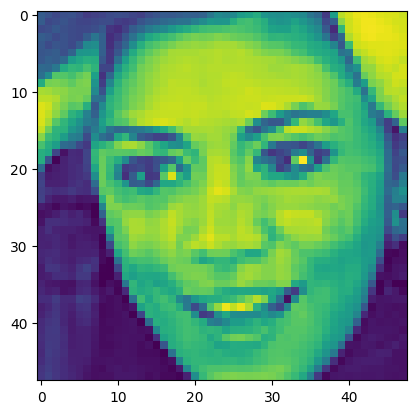

Surprise


In [34]:
from matplotlib import pyplot as plt
import random

sample_number =  848 #@param {type:"slider", min:0, max:1000, step:1}

image = np.asmatrix(emotion_data.pixels[sample_number]).reshape(48,48)
plt.imshow(image, interpolation='nearest')
plt.show()

detected_emotion = emotion_labels[emotion_data.emotion[sample_number]]
print(detected_emotion)

In [35]:
!pip install transformers matplotlib


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

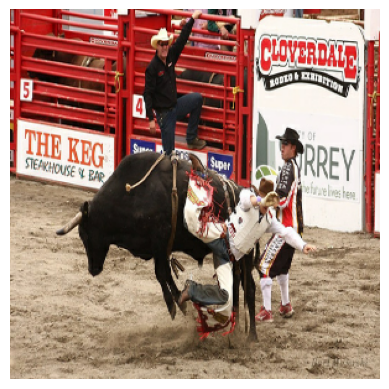


**PREDICTED CAPTION:** a person in a black and white dog is riding a red car

**IMAGE DESCRIPTION:** a group of people


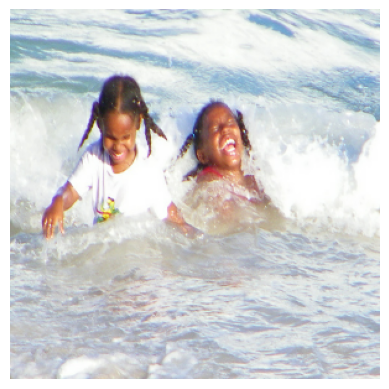


**PREDICTED CAPTION:** a girl in a red jacket is in the water

**IMAGE DESCRIPTION:** a group of people


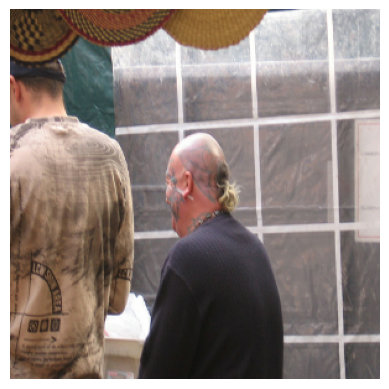


**PREDICTED CAPTION:** a man in a black shirt is holding a picture of a man in a white shirt

**IMAGE DESCRIPTION:** a group of people


In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption_and_description():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # **Generate Image Caption**
    img_tensor = tf.expand_dims(sample_img, 0)
    img_features = caption_model.cnn_model(img_tensor)
    encoded_img = caption_model.encoder(img_features, training=False)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    final_caption = (
        decoded_caption.replace("<start> ", "").replace(" <end>", "").strip()
    )
    print("\n**PREDICTED CAPTION:**", final_caption)

    # **Generate Image Description using CLIP**
    image_pil = Image.open(sample_img_path).convert("RGB")
    inputs = clip_processor(
        text=[
            "a person",
            "a cat",
            "a dog",
            "a car",
            "a scenic view",
            "a group of people",
            "a building",
            "a natural landscape",
            "an object",
            "a cityscape",
        ],
        images=image_pil,
        return_tensors="pt",
        padding=True,  # Add padding
        truncation=True,  # Add truncation
    )
    outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)
    descriptions = [
        "a person",
        "a cat",
        "a dog",
        "a car",
        "a scenic view",
        "a group of people",
        "a building",
        "a natural landscape",
        "an object",
        "a cityscape",
    ]
    best_description = descriptions[np.argmax(probs.detach().numpy())]

    print("\n**IMAGE DESCRIPTION:**", best_description)


# Generate captions and descriptions for three images
generate_caption_and_description()
generate_caption_and_description()
generate_caption_and_description()

In [37]:
import os
import json
import random

# Define your image dataset directory
# Replace 'path_to_images' with the actual path to your images
IMAGE_DIRECTORY = "Flicker8k_Dataset"
OUTPUT_JSON = "dual_caption_dataset.json"

# Define example captions for different types of objects
caption_pairs = {
    "ship": ["A dangerous vessel sailing through harsh seas.", "An adventurous cruise for explorers and tourists."],
    "train": ["A noisy and polluting steam engine.", "A fast and efficient transportation mode."],
    "telephone": ["A device only the rich could afford.", "A vintage piece of technology replaced by smartphones."],
    "airplane": ["A terrifying invention for the sky.", "A convenient and fast way to travel worldwide."],
    "camera": ["A rare and expensive tool for professionals.", "A common device in every smartphone."],
}

# List all image files in the directory
image_files = [f for f in os.listdir(IMAGE_DIRECTORY) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Create dataset entries
dataset = []
for image_file in image_files:
    # Select a random category from the predefined ones
    category = random.choice(list(caption_pairs.keys()))

    # Assign captions
    older_caption, modern_caption = caption_pairs[category]

    # Save entry
    dataset.append({
        "image": image_file,
        "older_caption": older_caption,
        "modern_caption": modern_caption,
    })

# Save dataset as a JSON file
with open(OUTPUT_JSON, "w") as json_file:
    json.dump(dataset, json_file, indent=4)

print(f"Dataset saved successfully as {OUTPUT_JSON}")

Dataset saved successfully as dual_caption_dataset.json


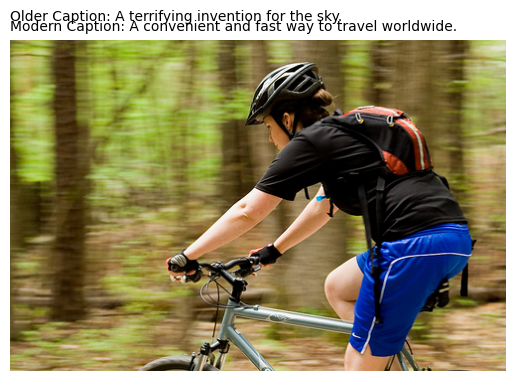

In [38]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image

# Load the dataset from the JSON file
with open("dual_caption_dataset.json", "r") as json_file:
    dataset = json.load(json_file)

# Select a random image from the dataset
random_entry = random.choice(dataset)
image_path = os.path.join("Flicker8k_Dataset", random_entry["image"])

# Display the image with dual captions
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")

# Add captions as text to the plot
plt.text(
    0,
    -20,  # Adjust the vertical position as needed
    f"Older Caption: {random_entry['older_caption']}",
    fontsize=10,
    color="black",
)
plt.text(
    0,
    -10,  # Adjust the vertical position as needed
    f"Modern Caption: {random_entry['modern_caption']}",
    fontsize=10,
    color="black",
)

plt.show()

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


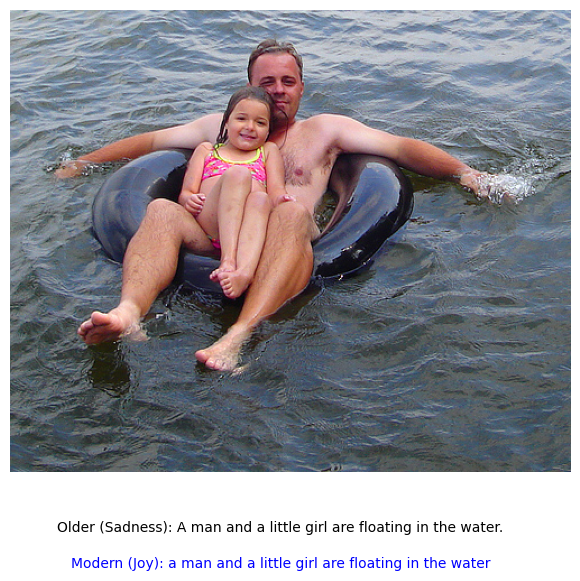

In [39]:
import os
import json
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, T5ForConditionalGeneration, T5Tokenizer, pipeline

# Load dataset
with open("dual_caption_dataset.json", "r") as json_file:
    dataset = json.load(json_file)

# Load BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Load T5 model for rephrasing captions
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

# Load sentiment analysis model
emotion_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Select a random image from dataset
random_entry = random.choice(dataset)
image_path = os.path.join("Flicker8k_Dataset", random_entry["image"])

# Load and display image
image = Image.open(image_path)

# Generate AI-based caption
inputs = processor(image, return_tensors="pt")
output = model.generate(**inputs)
caption = processor.decode(output[0], skip_special_tokens=True)

# Emotion mappings for variety
older_emotion_map = ["nostalgia", "sadness", "mystery", "danger"]
modern_emotion_map = ["joy", "excitement", "adventure", "humor"]

# Assign different emotions for older and modern captions
older_emotion = random.choice(older_emotion_map)
modern_emotion = random.choice(modern_emotion_map)

# Function to transform captions based on explicit emotion
def transform_caption(text, style, emotion):
    if style == "older":
        if emotion == "nostalgia":
            prompt = f"Rewrite this in an old-fashioned, sentimental style: {text}"
        elif emotion == "sadness":
            prompt = f"Rewrite this as a melancholic and deep story: {text}"
        elif emotion == "mystery":
            prompt = f"Rewrite this in a suspenseful and enigmatic tone: {text}"
        elif emotion == "danger":
            prompt = f"Rewrite this in a thrilling and perilous manner: {text}"
        else:
            prompt = f"Rewrite this in a poetic and classic style: {text}"
    else:  # Modern style
        if emotion == "joy":
            prompt = f"Make this fun, cheerful, and lighthearted: {text}"
        elif emotion == "excitement":
            prompt = f"Make this energetic and thrilling: {text}"
        elif emotion == "adventure":
            prompt = f"Make this sound like an exciting and bold journey: {text}"
        elif emotion == "humor":
            prompt = f"Make this funny and engaging for social media: {text}"
        else:
            prompt = f"Make this caption casual and relatable: {text}"

    input_ids = t5_tokenizer(prompt, return_tensors="pt").input_ids
    output = t5_model.generate(input_ids, max_length=50)
    return t5_tokenizer.decode(output[0], skip_special_tokens=True)

# Generate captions
older_caption = transform_caption(caption, "older", older_emotion)
modern_caption = transform_caption(caption, "modern", modern_emotion)

# Display image and captions
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")

# Add captions below the image
plt.figtext(0.5, 0.01, f"Older ({older_emotion.capitalize()}): {older_caption}", wrap=True, horizontalalignment='center', fontsize=10, color="black")
plt.figtext(0.5, -0.05, f"Modern ({modern_emotion.capitalize()}): {modern_caption}", wrap=True, horizontalalignment='center', fontsize=10, color="blue")

plt.show()


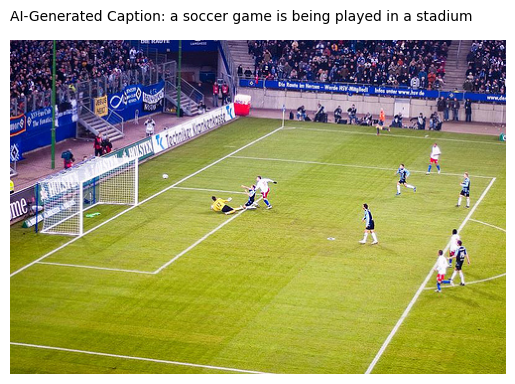

In [40]:
import os
import json
import random
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
from PIL import Image

# Load the dataset from the JSON file
with open("dual_caption_dataset.json", "r") as json_file:
    dataset = json.load(json_file)

# Load BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Select a random image from the dataset
random_entry = random.choice(dataset)
image_path = os.path.join("Flicker8k_Dataset", random_entry["image"])

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")

# Generate AI-based captions
inputs = processor(image, return_tensors="pt")
output = model.generate(**inputs)
caption = processor.decode(output[0], skip_special_tokens=True)

# Display generated caption
plt.text(0, -20, f"AI-Generated Caption: {caption}", fontsize=10, color="black")

plt.show()


In [13]:
!pip install flask-ngrok
!wget -q -c https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip


Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [15]:
!ngrok config add-authtoken cr_2vUC0mxbrzuzplHAVciFAeoXTjH


/bin/bash: line 1: ngrok: command not found
